# Variational Autoencoders 

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import matplotlib.pyplot as plt

import io
from datetime import datetime

%load_ext tensorboard

Building on the [this Keras tutorial](https://keras.io/examples/generative/vae/), I added 

- TensorBoard logging of the latent clusters and image samples after each epoch;
- an additional callback to adjust the KL-loss weight as training progresses (TODO).


## Convolutional variational autoencoder

The VAE model combines the encoder and decoder in with a custom training step.

In [5]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon


class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.latent_dim = 2
        self.encoder = self.get_encoder()
        self.decoder = self.get_decoder()
        
    def get_encoder(self):
        encoder_inputs = keras.Input(shape=(28, 28, 1))
        x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
        x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
        x = layers.Flatten()(x)
        x = layers.Dense(16, activation="relu")(x)

        z_mean = layers.Dense(self.latent_dim, name="z_mean")(x)
        z_log_var = layers.Dense(self.latent_dim, name="z_log_var")(x)

        z = Sampling()([z_mean, z_log_var])

        return keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
    
    def get_decoder(self):
        latent_inputs = keras.Input(shape=(self.latent_dim,))

        x = layers.Dense(7 * 7 * 64, activation="relu")(latent_inputs)
        x = layers.Reshape((7, 7, 64))(x)
        x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
        x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
        decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)

        return keras.Model(latent_inputs, decoder_outputs, name="decoder")

    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]
            
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                keras.losses.binary_crossentropy(data, reconstruction)
            ) # per-pixel loss
            reconstruction_loss *= 28 * 28
            kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
            kl_loss = tf.reduce_mean(kl_loss)
            kl_loss *= -0.5
            total_loss = reconstruction_loss + kl_loss
        
        # calculate gradients     
        grads = tape.gradient(total_loss, self.trainable_weights)
        
#         # weight norms
#         old_weights = {weight.name: weight.numpy() for weight in self.trainable_weights}
#         param_scale = {name: np.linalg.norm(weight.ravel()) for name, weight in old_weights.items()}
        
        # update the weights
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
          
        # new weights and update ratio
#         new_weights = {weight.name: weight.numpy() for weight in self.trainable_weights}
#         updates = {name: new_weights[name]-old_weights[name] for name in new_weights}
#         update_scale = {name: np.linalg.norm(weight.ravel()) for name in updates}
        
#         update_ratio = {name: update_scale[name]/param_scale[name] for name in update_scale}
        
        return  {
            "loss/total_loss": total_loss,
            "loss/reconstruction_loss": reconstruction_loss,
            "loss/kl_loss": kl_loss,
            "learning_rate": self.optimizer.lr,
        }

## Training 

We load the MNIST data and optionally down sample:

In [9]:
(x_train, _), (x_test, y_test) = keras.datasets.mnist.load_data()

sample_size = None

if sample_size:
    train_data = x_train[np.random.choice(x_train.shape[0], sample_size)]
else:
    train_data = x_train
    
train_data = np.expand_dims(train_data, -1).astype("float32") / 255

val_data = np.expand_dims(x_test, -1).astype("float32") / 255
val_labels = y_test

Some logging utility functions for recording how the latent space is changing:

In [7]:
# logging
logdir = "variational_logs/scalars/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)

# image callbacks - source: https://www.tensorflow.org/tensorboard/image_summaries
logdir = "variational_logs/image/" + datetime.now().strftime("%Y%m%d-%H%M%S")
file_writer = tf.summary.create_file_writer(logdir + 'latent/')

def plot_to_image(figure):
    """Converts the matplotlib plot specified by 'figure' to a PNG image and
    returns it. The supplied figure is closed and inaccessible after this call."""
    # Save the plot to a PNG in memory.
    buf = io.BytesIO()
    plt.savefig(buf, format='png')
    # Closing the figure prevents it from being displayed directly inside
    # the notebook.
    plt.close(figure)
    buf.seek(0)
    # Convert PNG buffer to TF image
    image = tf.image.decode_png(buf.getvalue(), channels=4)
    # Add the batch dimension
    image = tf.expand_dims(image, 0)
    return image

def plot_generative(encoder, decoder, show=False):
    # display a n*n 2D manifold of digits
    n = 10
    digit_size = 28
    scale = 2.0
    figsize = 15
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit

    fig = plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range + 1
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="Greys_r")
    if show:
        plt.show()
        
    return fig

def plot_latent_cluster(data, labels, show=False):
    # display a 2D plot of the digit classes in the latent space
    z_mean, _, _ = encoder.predict(data)
    figure = plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=labels)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    if show:
        plt.show()

    return figure

def log_latent(epoch, logs):
    cluster_figure = plot_latent_cluster(val_data, val_labels)
    cluster_image = plot_to_image(cluster_figure)
    
    gen_figure = plot_generative(encoder, decoder)
    gen_image = plot_to_image(gen_figure)

    with file_writer.as_default():
        tf.summary.image("Latent clusters", cluster_image, step=epoch)
        tf.summary.image("Generative", gen_image, step=epoch)


# Define the per-epoch callback.
latent_plot_callback = keras.callbacks.LambdaCallback(on_epoch_end=log_latent)

In [8]:
encoder = get_encoder()
decoder = get_decoder()
vae = VAE(encoder, decoder)
vae.compile(optimizer="adam")

history = vae.fit(train_data, 
                    epochs=30, 
                    batch_size=128, 
                    verbose=1,
                    callbacks=[tensorboard_callback, latent_plot_callback],
          
)

Epoch 1/30
  1/469 [..............................] - ETA: 0s - loss/total_loss: 544.0129 - loss/reconstruction_loss: 544.0117 - loss/kl_loss: 0.0012 - learning_rate: 0.0010WARNING:tensorflow:From /home/daniel/anaconda3/envs/deeplearning/lib/python3.7/site-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
469/469 [==============================] - 150s 321ms/step - loss/total_loss: 207.7001 - loss/reconstruction_loss: 205.4556 - loss/kl_loss: 2.2444 - learning_rate: 0.0010
Epoch 2/30
469/469 [==============================] - 160s 341ms/step - loss/total_loss: 165.9512 - loss/reconstruction_loss: 162.2096 - loss/kl_loss: 3.7416 - learning_rate: 0.0010
Epoch 3/30
469/469 [==============================] - 152s 324ms/step - loss/total_loss: 161.3318 - loss/reconstruction_loss: 157.5458 - loss/kl_loss: 3.7861 - learni

KeyboardInterrupt: 

In [45]:
%tensorboard --logdir variational_logs/

## Model evaluation

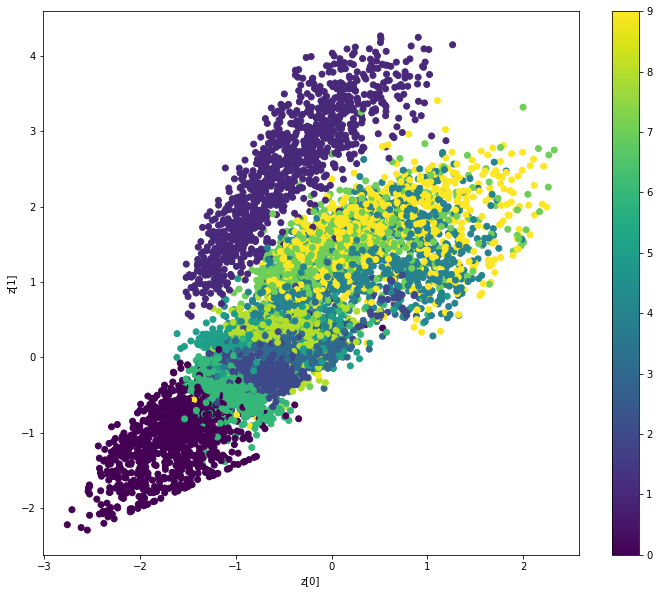

In [10]:
fig = plot_latent_cluster(val_data, val_labels)

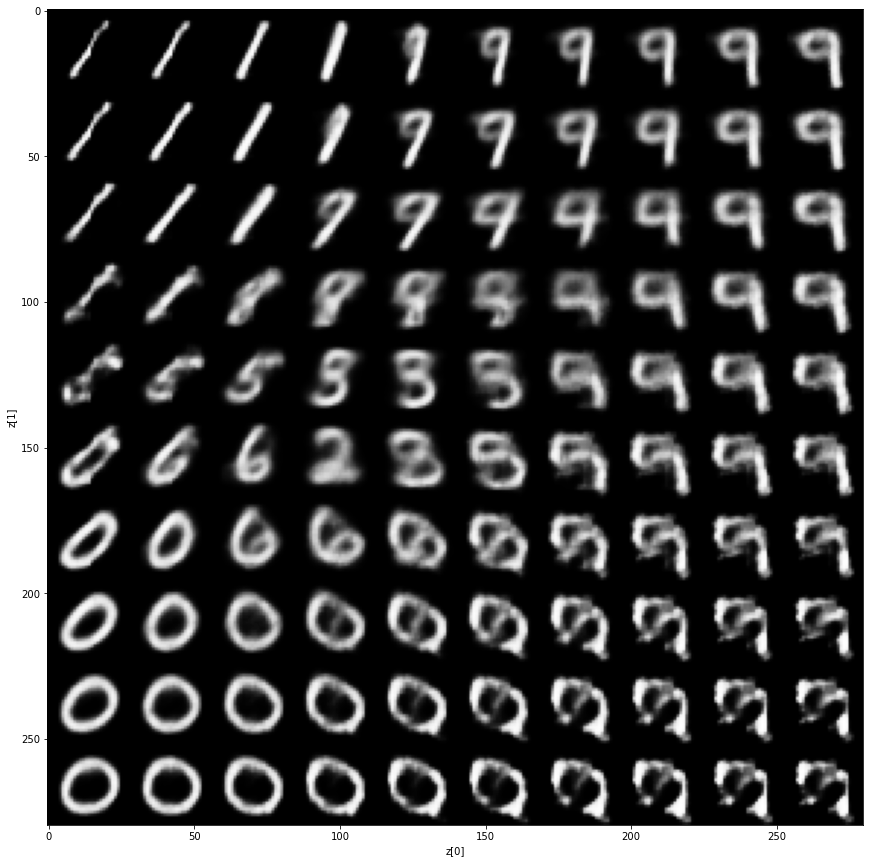

In [11]:
fig = plot_generative(encoder, decoder, show=True)